In [14]:
import cv2
import os
import numpy as np

# -------------------------------
# Setup paths and load the Haar cascade
# -------------------------------

# Path to the folder with normalized (processed) images
DATA_DIR = 'processed_images'
TRUMP_DIR = os.path.join(DATA_DIR, 'trump')
NON_TRUMP_DIR = os.path.join(DATA_DIR, 'non_trump')

# Load the Haar cascade for face detection (this uses OpenCV’s built-in file)
cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

# -------------------------------
# Prepare training data
# -------------------------------

# These lists will store face images (as numpy arrays) and corresponding labels
faces = []
labels = []

def process_directory(directory, label):
    """
    Reads all images from a given directory, detects the first face in each image,
    resizes it to a fixed size, and appends it to the training data list.
    
    Args:
        directory (str): Path to the image directory.
        label (int): Label to assign (e.g. 1 for Trump, 0 for non-Trump).
    """
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        img = cv2.imread(file_path)
        if img is None:
            print(f"Warning: Could not load image {file_path}. Skipping.")
            continue

        # Convert to grayscale (face recognizers usually work on gray images)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        detected_faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5
        )
        
        # Use the first detected face (if any)
        for (x, y, w, h) in detected_faces:
            face_roi = gray[y:y+h, x:x+w]
            # Resize to a common size (adjust as needed)
            face_resized = cv2.resize(face_roi, (200, 200))
            faces.append(face_resized)
            labels.append(label)
            # Process only the first detected face per image
            break

# Process both directories
process_directory(TRUMP_DIR, label=1)      # Label 1 for Trump
process_directory(NON_TRUMP_DIR, label=0)    # Label 0 for non-Trump

# Convert our lists to numpy arrays (as required by the recognizer)
faces_np = np.array(faces)
labels_np = np.array(labels)

# -------------------------------
# Train the Face Recognizer
# -------------------------------

# Create an LBPH face recognizer (you can also experiment with Eigen or Fisher recognizers)
recognizer = cv2.face.LBPHFaceRecognizer_create()

print("Training face recognizer on {} images...".format(len(faces_np)))
recognizer.train(faces_np, labels_np)
# Optionally, save the trained model for later use
recognizer.save('face_recognizer_model.yml')
print("Training complete. Model saved as 'face_recognizer_model.yml'.")

# -------------------------------
# Prediction function for new images
# -------------------------------

def predict_image(image_path):
    """
    Loads an image, detects the face(s) using Haar cascades, and predicts
    whether the face is Trump or not using the trained recognizer.
    
    Args:
        image_path (str): Path to the image file.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5
    )
    
    for (x, y, w, h) in detected_faces:
        face_roi = gray[y:y+h, x:x+w]
        try:
            face_resized = cv2.resize(face_roi, (200, 200))
        except Exception as e:
            print("Error resizing face region:", e)
            continue
        
        label, confidence = recognizer.predict(face_resized)
        # Lower confidence values mean a better match. Adjust the threshold as needed.
        label_text = "Trump" if label == 1 else "Non-Trump"
        
        # Draw a rectangle and label around the face
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(
            img,
            f"{label_text} ({confidence:.2f})",
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            (0, 255, 0),
            2
        )
    
    # Display the result
    cv2.imshow("Prediction", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# -------------------------------
# Main function to run the prediction demo
# -------------------------------

if __name__ == '__main__':
    # Replace 'test_image.jpg' with the path to any test image you want to classify.
    test_image_path = 'C:/Users/teddy/OneDrive/Documents/Documents/Cst-440/processed_images/trump/812637_face_0'
    if os.path.exists(test_image_path):
        predict_image(test_image_path)
    else:
        print(f"Test image {test_image_path} not found. Please provide a valid image path.")


Training face recognizer on 6054 images...
Training complete. Model saved as 'face_recognizer_model.yml'.
Test image C:/Users/teddy/OneDrive/Documents/Documents/Cst-440/processed_images/trump/812637_face_0 not found. Please provide a valid image path.


Test image C:/Users/teddy/OneDrive/Documents/Documents/Cst-440/processed_images/trump/812637_face_0.jpeg not found. Skipping single image demo.

Evaluating model on training images (for demonstration purposes)...
Confusion Matrix:
[[5492    0]
 [   0  562]]

Classification Report:
              precision    recall  f1-score   support

   Non-Trump       1.00      1.00      1.00      5492
       Trump       1.00      1.00      1.00       562

    accuracy                           1.00      6054
   macro avg       1.00      1.00      1.00      6054
weighted avg       1.00      1.00      1.00      6054



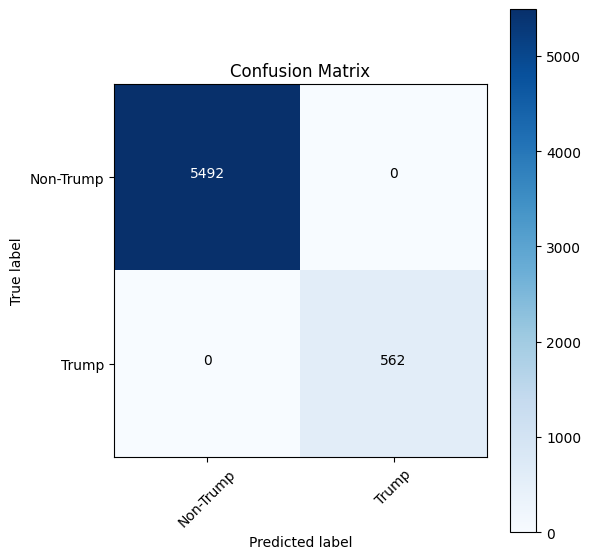

In [16]:
# --- Additional Evaluation and Visualization Code ---

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

def predict_label_for_image(image_path):
    """
    Loads an image, detects the face, resizes it, and returns the predicted label.
    If no face is detected, returns None.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Unable to load image {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5
    )
    for (x, y, w, h) in detected_faces:
        face_roi = gray[y:y+h, x:x+w]
        try:
            face_resized = cv2.resize(face_roi, (200, 200))
        except Exception as e:
            print(f"Error resizing face region in {image_path}: {e}")
            continue
        label, confidence = recognizer.predict(face_resized)
        return label  # Assume one face per image; adjust if needed.
    return None

def evaluate_model():
    true_labels = []
    predicted_labels = []
    
    # Loop through both directories and record predictions.
    for directory, label in [(TRUMP_DIR, 1), (NON_TRUMP_DIR, 0)]:
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            pred = predict_label_for_image(file_path)
            if pred is None:
                # Skip images where no face was detected.
                continue
            true_labels.append(label)
            predicted_labels.append(pred)
    
    # Compute the confusion matrix and classification report.
    cm = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=["Non-Trump", "Trump"]))
    
    # Plot the confusion matrix.
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Non-Trump", "Trump"], rotation=45)
    plt.yticks(tick_marks, ["Non-Trump", "Trump"])
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Optionally run your test image prediction first
    test_image_path = 'C:/Users/teddy/OneDrive/Documents/Documents/Cst-440/processed_images/trump/812637_face_0.jpeg'
    if os.path.exists(test_image_path):
        print("Running prediction on a single test image...")
        predict_image(test_image_path)
    else:
        print(f"Test image {test_image_path} not found. Skipping single image demo.")

    # Now evaluate the model on all images from your processed directories.
    print("\nEvaluating model on training images (for demonstration purposes)...")
    evaluate_model()


In [17]:
# --- Additional Graphs for Overfitting Analysis ---

from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)

# Split the data into training and validation sets (e.g. 70% train, 30% validation)
train_faces, val_faces, train_labels, val_labels = train_test_split(
    faces_np, labels_np, test_size=0.3, random_state=42, stratify=labels_np
)

# We'll simulate a learning curve by training on increasing fractions of the training set.
fractions = np.linspace(0.1, 1.0, 10)  # 10 fractions: 0.1, 0.2, ... 1.0
train_acc_list = []
val_acc_list = []
num_train_samples = []

for frac in fractions:
    # Determine the number of training samples for this fraction.
    n_samples = max(1, int(frac * len(train_faces)))
    num_train_samples.append(n_samples)
    
    # Randomly select n_samples from the training data.
    indices = np.random.choice(len(train_faces), n_samples, replace=False)
    subset_train_faces = np.array([train_faces[i] for i in indices])
    subset_train_labels = np.array([train_labels[i] for i in indices])
    
    # Create and train a new LBPH recognizer on this subset.
    model = cv2.face.LBPHFaceRecognizer_create()
    model.train(subset_train_faces, subset_train_labels)
    
    # Evaluate training accuracy on the subset.
    correct_train = 0
    for i in range(len(subset_train_faces)):
        pred, conf = model.predict(subset_train_faces[i])
        if pred == subset_train_labels[i]:
            correct_train += 1
    train_acc = correct_train / len(subset_train_faces)
    
    # Evaluate validation accuracy on the full validation set.
    correct_val = 0
    for i in range(len(val_faces)):
        pred, conf = model.predict(val_faces[i])
        if pred == val_labels[i]:
            correct_val += 1
    val_acc = correct_val / len(val_faces)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

# Plot the learning curve.
plt.figure(figsize=(8, 6))
plt.plot(num_train_samples, train_acc_list, marker='o', label='Training Accuracy')
plt.plot(num_train_samples, val_acc_list, marker='o', label='Validation Accuracy')
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for LBPH Face Recognizer")
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 